In [28]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from pathlib import Path
from matplotlib import pyplot as plt
from skimage import feature

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import requests
import sklearn
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
import pickle
import gzip
import graphviz
import math

In [2]:
# mnist loader code from:
# https://pytorch.org/tutorials/beginner/nn_tutorial.html

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [98]:
def show_mnist(x):
    plt.imshow(x.reshape((28, 28)),cmap='Greys_r')
    plt.show()

# Linear Model

In [38]:
# parameters for logistic regression from :
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html
clf = sklearn.linear_model.LogisticRegression(solver='saga', 
                                              penalty='l1',
                                              multi_class='multinomial', 
                                              tol=0.1).fit(x_train, y_train)
clf.score(x_valid, y_valid)

0.9296

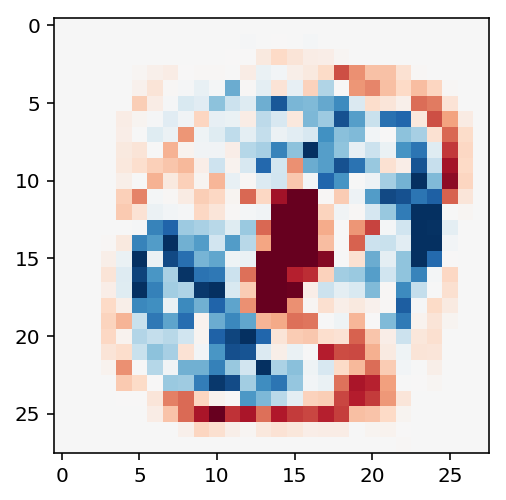

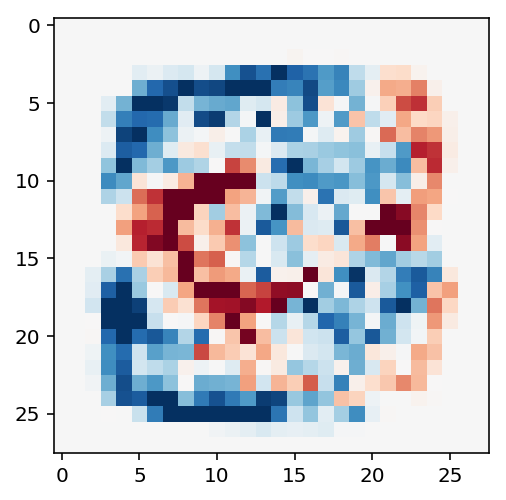

In [82]:
scale = 0.4
plt.imshow(clf.coef_[0].reshape((28, 28)),
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
plt.show()
plt.imshow(clf.coef_[3].reshape((28, 28)),
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
plt.show()

In [71]:
clf.coef_[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        4.81118557e-03,  0.00000000e+00, -1.56610724e-04,  0.00000000e+00,
        6.49496071e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

# Interpretable Features

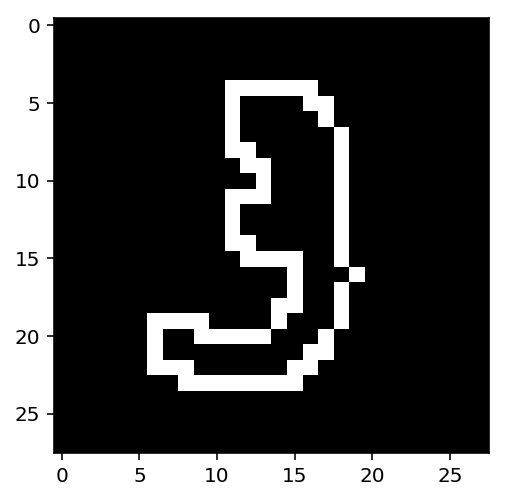

In [9]:
plt.imshow(feature.canny(x_train[10].reshape((28, 28))), cmap='Greys_r')

In [75]:
feature.corner_peaks(feature.corner_harris(x_train[10].reshape((28, 28))), 
                     min_distance=5, threshold_rel=0)

array([[ 5, 11],
       [13, 11],
       [20,  7]])

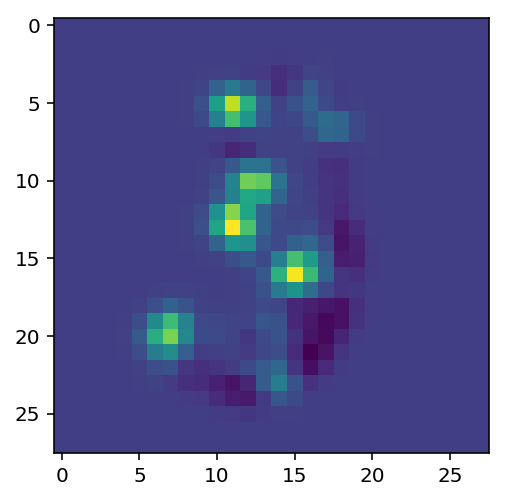

In [76]:
plt.imshow(feature.corner_harris(x_train[10].reshape((28, 28))))

In [3]:
%%time

# hand-engineering features
# 1] average luminosity
# 2] proportion of canny edge detected image that is filled
# 3] number of corner using corner_peak and corner_harris and some reasonable min (maybe 5)
# 4] max width of pixels

interp_x_train = []
interp_x_valid = []

for x in x_train:
    avg_lumin = np.sum(x)/(28*28)
    edge_prop = np.sum(feature.canny(x.reshape((28, 28))))/(28*28)
    num_corners = len(feature.corner_peaks(feature.corner_harris(x.reshape((28, 28))), 
                     min_distance=5, threshold_rel=0))
    max_width = max(np.sum(x.reshape((28,28)) > 0, axis=1))
    max_height = max(np.sum(x.reshape((28,28)) > 0, axis=0))
    
    interp_x_train.append([
        avg_lumin,
        edge_prop,
        num_corners,
        max_width,
        max_height
    ])
    
interp_x_train = np.array(interp_x_train)

CPU times: user 1min 53s, sys: 132 ms, total: 1min 53s
Wall time: 1min 53s


In [14]:
clf = sklearn.tree.DecisionTreeClassifier(max_depth = 3, criterion="gini")
clf.fit(interp_x_train, y_train)
print(clf.score(interp_x_train, y_train))

0.33354


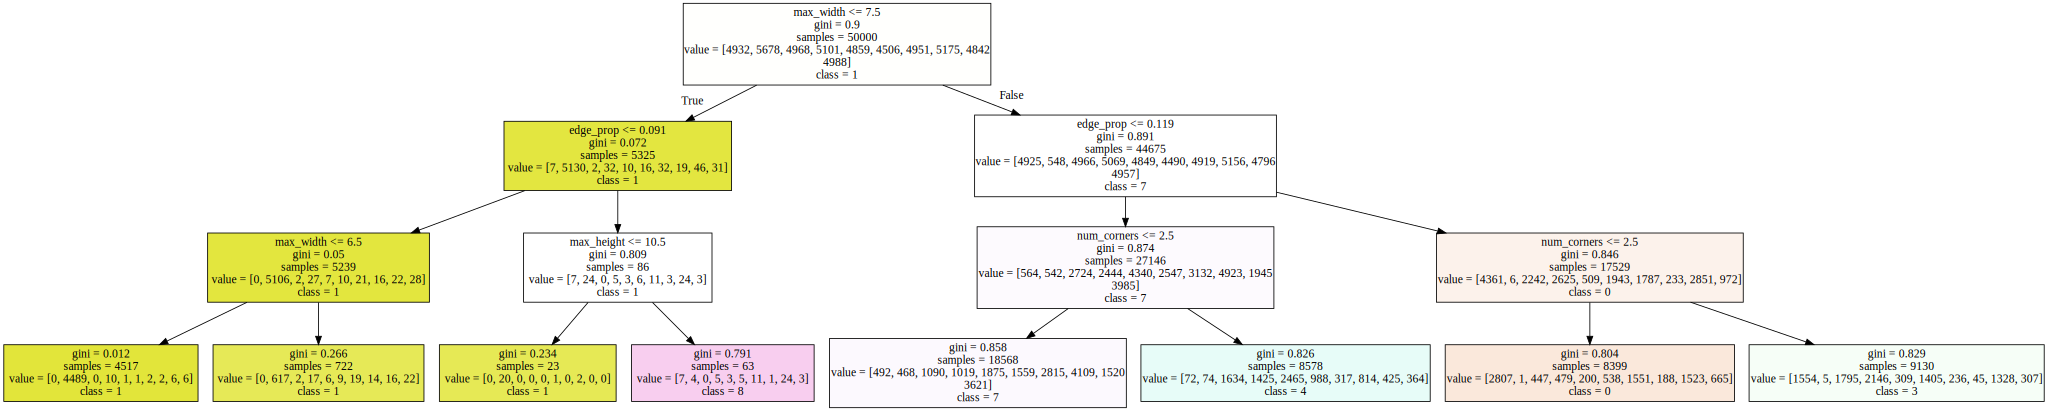

In [15]:
dot_data = sklearn.tree.export_graphviz(clf, out_file = None, 
                                feature_names = [
                                    "avg_lumin", "edge_prop", "num_corners", "max_width", "max_height"
                                ],
                                class_names = [str(i) for i in range(0, 10)],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [13]:
clf = sklearn.linear_model.LogisticRegression(solver='saga', 
                                              penalty='l1',
                                              C=10,
                                              max_iter=200,
                                              multi_class='multinomial').fit(interp_x_train, y_train)
clf.fit(interp_x_train, y_train)
print(clf.score(interp_x_train, y_train))
for c in clf.coef_:
    print(np.round(c, decimals=2))

/home/owen/program_files/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.46714
[32.66 28.24 -0.21 -0.2  -0.2 ]
[ 5.15 -5.61 -0.98 -1.25 -0.01]
[-7.46 -6.79  0.75  0.49 -0.04]
[ 2.59  4.77  1.04 -0.02  0.04]
[-22.35 -19.43   0.66   0.39   0.09]
[-2.89  0.31  0.52  0.16 -0.26]
[ 4.49  2.87 -0.94  0.1  -0.04]
[-21.59 -28.91  -0.31   0.47  -0.06]
[16.7  23.96  0.04 -0.3   0.31]
[-7.31  0.53 -0.57  0.04  0.2 ]


/home/owen/program_files/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


# Neural Net Interpretability

In [65]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape

/home/owen/program_files/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [66]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = torch.nn.functional.relu(self.conv1(xb))
        xb = torch.nn.functional.relu(self.conv2(xb))
        xb = torch.nn.functional.relu(self.conv3(xb))
        xb = torch.nn.functional.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

loss_func = torch.nn.functional.cross_entropy
lr = 0.1
epochs = 10
bs = 64
train_data = TensorDataset(x_train, y_train)
valid_data = TensorDataset(x_valid, y_valid)

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

def get_model():
    model = MNIST_Net()
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    return(model, opt)

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
    print(accuracy(model.forward(x_valid), y_valid))

In [67]:
%%time
train_dl, valid_dl = get_data(train_data, valid_data, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.29766359733343123
1 0.20563192915320397
2 0.2096680709719658
3 0.1848541338145733
4 0.14094552401304244
5 0.14855193548202514
6 0.14791034851670265
7 0.13577543746829032
8 0.14206985997855665
9 0.15643914679288864
tensor(0.9521)
CPU times: user 5min 23s, sys: 2min 48s, total: 8min 11s
Wall time: 1min 12s


In [71]:
model.eval()

MNIST_Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)

In [92]:
torch.argmax(model.forward(x_valid[0]))

tensor(3)

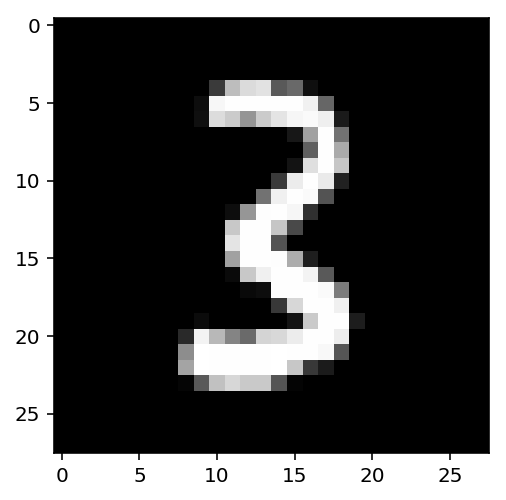

In [99]:
show_mnist(x_valid[0])

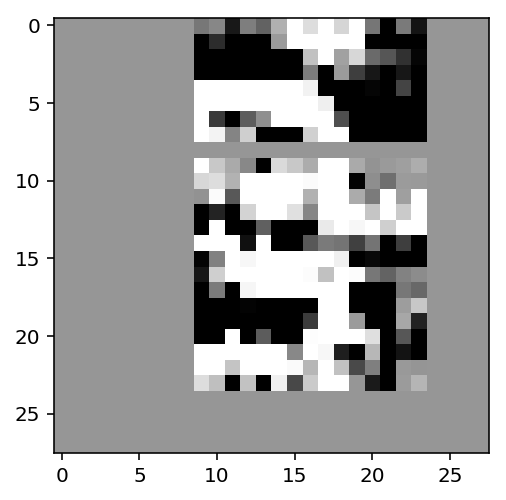

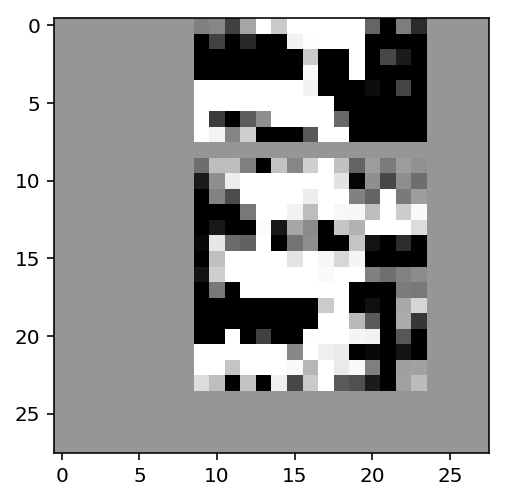

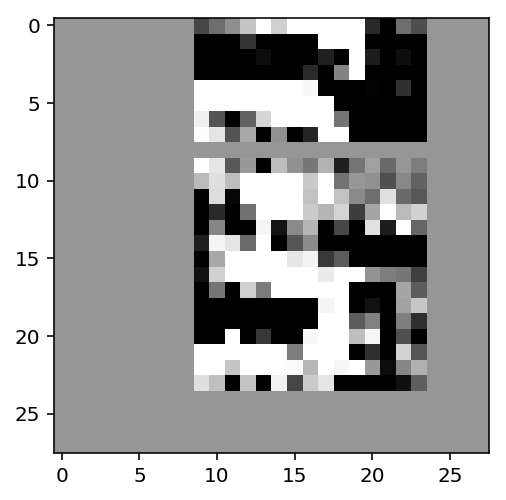

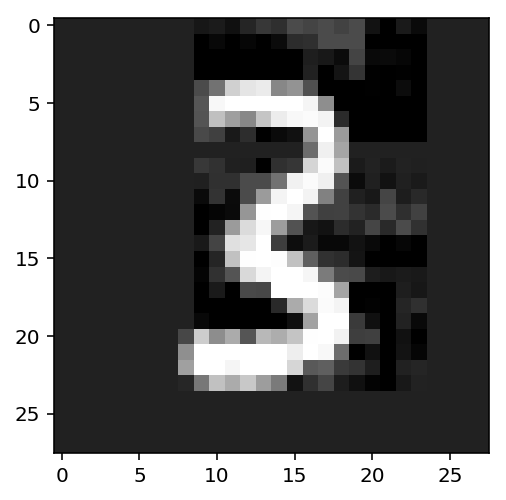

tensor([[ 0.5324,  2.1158, 13.9041, 29.6140,  4.2903, 14.5835,  7.6240, 10.4082,
         11.9075,  7.7537]], grad_fn=<ViewBackward>)
tensor(3)


In [228]:
img = x_valid[0].clone()
img.requires_grad = True

for i in range(3):
    logits = model.forward(img)
    loss = -(logits[0][3]**2).mean()
    loss.backward()
    with torch.no_grad():
        g = img.grad
        g = torch.clamp(g/g.abs().mean(), -1, 1)
        show_mnist(-g)
        img.data = img - 0.05*g
        
show_mnist(img.detach())
print(model.forward(img))
print(torch.argmax(model.forward(img)))